# Basic Segmentation 

In this exercise, we will apply basic segmentation methods on medical images. The methods are based on Thresholding, Region Growing, Edge Detection, Clustering, and Superpixel.

We will be working with different modality images like CT and MRI. 

## Part 1: Basic Information

If you do not have any jupyter notebook in your system you can easily install it from here (https://test-jupyter.readthedocs.io/en/latest/install.html) using Anaconda. 

### Load libraries
The first step is to load our needed libraries. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#Uncomment if you did not install cv2 before
#!pip install opencv-python

### Read and Plot images

In [3]:
# Read the image
image = cv2.imread('img/mri_brain19.png',0) # Load a gray image

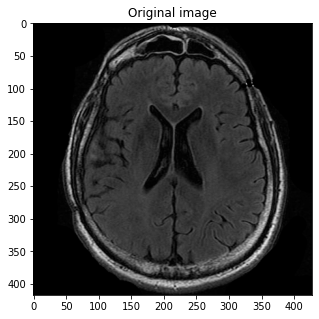

In [4]:
# Plot the image
fig = plt.figure(figsize = (5,5)) # Create a figure
plt.imshow(image, cmap = 'gray')  # Show the figure (Cmap sets the lightness values of the matplotlib colormaps)
plt.title('Original image') # Give a name to yuor plot

plt.show() # Once we have are all set, we show the figure. 

## Part 2:  Image Histogram

Histograms provide information about the distribution of the intensity values of an image. 

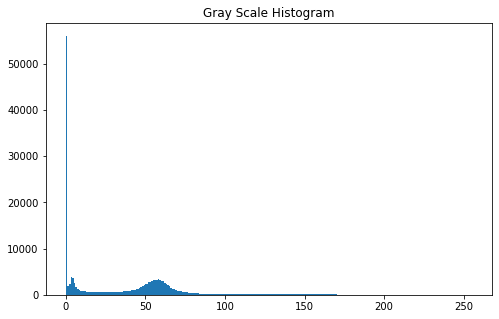

In [5]:
plt.figure(figsize = (8,5))

plt.hist(image.ravel(), bins=256) # Plot our histogram (it takes a single array, the number of bins)
plt.title('Gray Scale Histogram')

plt.show()



We can also merge these two figures in one

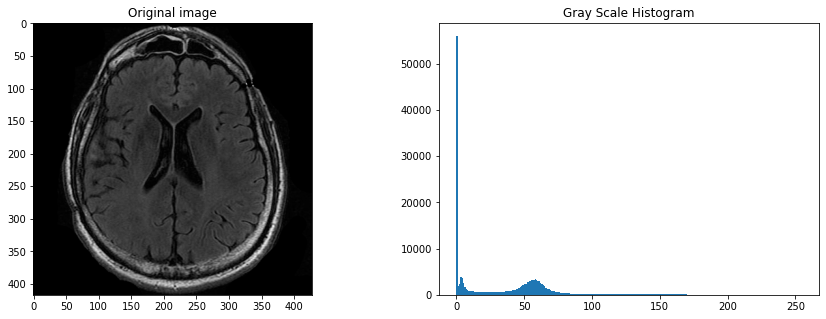

In [6]:
fig = plt.figure(figsize = (15,5))

ax1 = fig.add_subplot(121) # Add a subplot to plot our figure (1 row, two columns, our first subplot)
ax1.imshow(image, cmap = 'gray')
ax1.set_title('Original image') 

ax2 = fig.add_subplot(122) # Add a second subplot to plot our histogram (1 row, two columns, our second subplot)
ax2.hist(image.ravel(), bins=256)
ax2.set_title('Gray Scale Histogram')

plt.show()


## Part 3: Basic Segmentation (Thresholding)

Thresholding is the primary method of image segmentation, in which one or more threshold values is used to change a greyscale image into a binary image. 

### Local Thresholding

In [7]:
# Step 1: Create a black image (same size as our image) to store our results. 
segmented = np.zeros(shape=image.shape)
    
# Step 2: Segment using local thresholding (convert the black pixels to white if their intensity is less than threshold)
threshold = 50
segmented[image < threshold] = 255


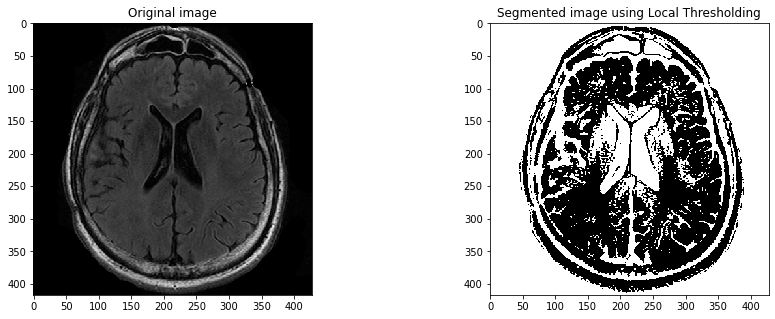

In [8]:
# we show our results     

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121) 
ax1.imshow(image, interpolation='none',  cmap='gray') 
ax1.set_title('Original image') 

ax2 = fig.add_subplot(122)
ax2.imshow(segmented, interpolation='none',  cmap='gray', vmin=0, vmax=255)
ax2.set_title('Segmented image using Local Thresholding') 
plt.show()
    

In [9]:
# TODO: Now, you can try other different threshold values to see the different segmented images.  

# You should see, if you select the threshold more than 70, you will see more pixels in the white color. 
# And also, if you select the threshold less than 10, you will see more pixels in the black color

### Global Thresholding

Let's find the best threshold value using the global thresholding.

36.68470610962988


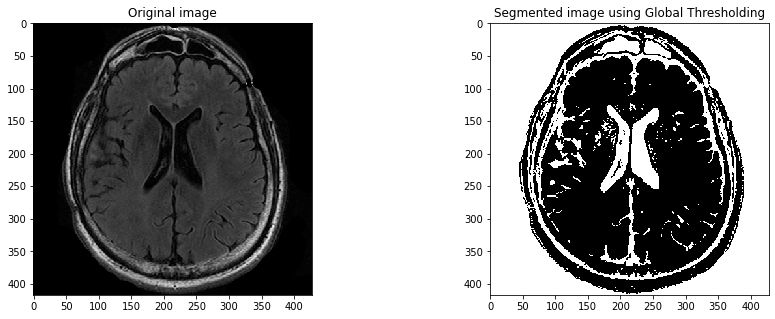

In [10]:
# Step 1: select an initial threshold
threshold_old = 150

while True:
    # Step 2: Segment the image using the old threshold value
    segmented = np.zeros(shape=image.shape)
    segmented[image < threshold_old] = 255
    
    # Step 3: Compute the mean intensity values for all pixels in the foreground region and the background region 
    m1 = np.mean(image[segmented==0.])
    m2 = np.mean(image[segmented==255.])
    
    # Step 4: Compute a new threshold value using average between m1 and m2
    threshold_new = (m1+m2)/2
    
    # Step 5: Repeat Step 2 through Step 4 until the difference between the new threshold and the old threshold is smaller than a predefined parameter
    if np.abs(threshold_old-threshold_new)<1:
        break
    else:
        threshold_old = threshold_new

print(threshold_new)

# Segment the image using the new threshold value
segmented = np.zeros(shape=image.shape)
segmented[image < threshold_new] = 255
    
# And now we show our results
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121) 
ax1.imshow(image, interpolation='none',  cmap='gray') 
ax1.set_title('Original image') 

ax2 = fig.add_subplot(122)
ax2.imshow(segmented, interpolation='none',  cmap='gray', vmin=0, vmax=255)
ax2.set_title('Segmented image using Global Thresholding') 
plt.show()

### Otsu Thresholding

Let's also  find the best threshold value using Otsu's method and segment the image using that. 

For this, we can use the opencv (cv2) package. Take a look at https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57

36.0


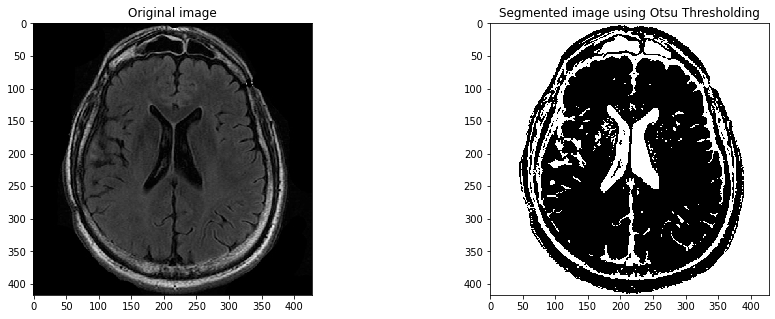

In [11]:
# Use cv2.threshold (It takes image, the initial threshold value, maximum value to use, thresholding type)
threshold_otsu, segmented_otsu = cv2.threshold(src=image, thresh=50, maxval=255, type=cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
print(threshold_otsu)

# And now we show our results. 
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121) 
ax1.imshow(image, interpolation='none',  cmap='gray') 
ax1.set_title('Original image') 

ax2 = fig.add_subplot(122)
ax2.imshow(segmented_otsu, interpolation='none',  cmap='gray', vmin=0, vmax=255)
ax2.set_title('Segmented image using Otsu Thresholding') 
plt.show()


## Part 4: Basic Segmentation (Region growing)

Region growing is a procedure that groups pixels or subregions into larger regions based on predefined criteria for growth. 
The basic approach is to start with a “seed” point, and from this seed regions grows by appending to the seed those neighbouring pixels that are similar to the seed.


In [26]:
# Step 1: We first need a seed point (root), let's pick a random point

rows, cols = image.shape[0], image.shape[1]  # Number of rows and colums from the 2D Image

seedX = np.random.uniform(0, cols, 1).astype(np.int32) # select x-Coordinate of the seed point
seedY = np.random.uniform(0, rows, 1).astype(np.int32) # select y-Coordinate of the seed point

print(seedY, seedX)

[137] [126]


In [27]:
# We need to have a function which gives us the neighbor pixels

def get4ngb(rows, cols, x, y):
    # Input: Coordinates of the center point (x,y)
    # Output: return list of possible neighbours (left, right, down and up neighbours)

    # initialize empty result list
    ngb = list()

    # left
    if x > 1:
        ngb += [[y, x-1]];

    # down
    if y < rows-1:
        ngb += [[y+1, x]];

    # right
    if x < cols-1:
        ngb += [[y, x+1]];

    # up
    if y > 1:
        ngb += [[y-1, x]];

    return ngb 



In [28]:
# Step 2: Now, we can grow the region from the selected seed point

image_blurred = cv2.GaussianBlur(image, ksize=(0, 0), sigmaX=1) # Apply Gaussian Blur to smoothe image and reduce noise. 

R = -np.ones(shape=(rows, cols)) # Create a map for the pixels
# we have not discovered yet (-1),
# we have discovered (0)
# we have discovered and meet the similarity condition (1). 


queue = [] # Define an empty list
# enqueue the root
queue.append([seedY, seedX])
    
# Set the root as "discovered"
R[seedY, seedX] = 0

# Continue while our queue is not empty
while len(queue) > 0:
    
    # 1) dequeue the first node of the queue
    v = queue[0]
    queue = queue[1:]
    
    # 2) Check the condition on the pixel v, using the similarity function
    dist = np.mean(np.abs(image_blurred[v[0], v[1]] - image_blurred[seedY, seedX]))
    
    # 3) if the condition is true (the current pixel and the seed point are similar)
    th = 20
    if dist < th:
        # Set the pixel v as "meet the similarity condition", that is, R[vy, vx] = 1
        R[v[0], v[1]] = 1
        
        # Find its neighbors
        nbgs = get4ngb(rows, cols, v[1], v[0])
        
        # Enqueue all of neighbors of pixel v  
        for i in range(0,len(nbgs)):
            qq = nbgs[i]
            
            # If they were not discovered yet:
            if (R[qq[0], qq[1]] < 0):
                
                #labeling them as "discovered",  R[vy, vx] = 0
                R[qq[0], qq[1]] = 0
                
                #enqueuing it 
                queue.append([qq[0], qq[1]])

segmented = R # R would be the same segmentation map


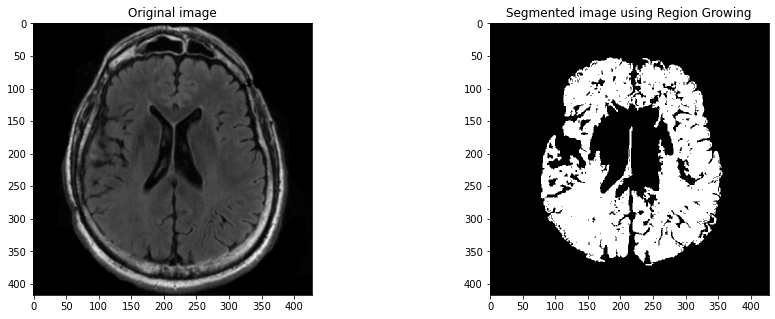

In [29]:
fig = plt.figure(figsize = (15,5)) 
ax1 = fig.add_subplot(121) 
ax1.imshow(image_blurred, cmap='gray')
ax1.set_title('Original image')  

ax2 = fig.add_subplot(122) 
ax2.imshow(R, interpolation='none',  cmap='gray') 
ax2.set_title('Segmented image using Region Growing')

plt.show()

In [30]:
# TODO: Now, you can try with other seed points 

# You should see, the result of region growing is often sensitive to the seed points. 

## Part 5: Basic Segmentation (Edge-based Methods) 

For Canny Edge Detection we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges. And, those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are taken to be edges. Otherwise, they are also classified as non-edges. 

For Canny Edge Detection, we can use the opencv. For this, take a look at https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

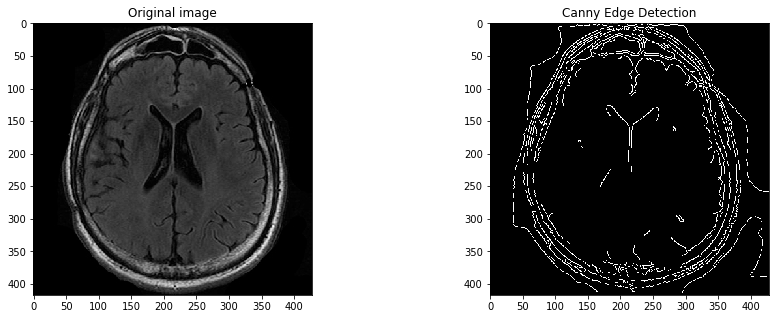

In [31]:
minVal = 100 
maxVal = 200

image_blurred = cv2.GaussianBlur(image, ksize=(0, 0), sigmaX=1) # Apply Gaussian Blur to smoothe image and reduce noise. 
image_canny = cv2.Canny(np.uint8(image_blurred*255), minVal, maxVal)


fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(image, interpolation='none',  cmap='gray') 
ax1.set_title('Original image') 

ax2 = fig.add_subplot(122)
ax2.imshow(image_canny, interpolation='none',  cmap='gray')
ax2.set_title('Canny Edge Detection')

plt.show()


In [40]:
# TODO: Now, you can try other different threshold values for the edges

# You should see, if you select minVal and maxVal close to each other, you will see less edges from the image. 
# You should see, if you select minVal and maxVal far from each other, you will see more edges from the image. 


## Part 6: Basic Segmentation (Kmeans Clustering)

The basic idea is to partition a set of pixels into a specified number of clusters. Finally, in k-means clustering, each pixel is assigned to the cluster with the nearest the cluster center.

The method includes of 4 steps:
1. Initializing: we need to select an initial set randomly for each cluster center
2. Assigning each sample to the nearest cluster set
3. Updating the cluster centers according to the current clusters
4. Repeating Step 2 and Step 3 and checking if the algorithm should be finished or not


In [25]:
# Step 0: Select the number of clusters
K = 3  

In [30]:
# Step 1: Select randomly an initial center for each cluster 

cxs = np.random.uniform(0, cols, K).astype(np.int32) 
cys = np.random.uniform(0, rows, K).astype(np.int32)

centers = np.zeros(shape=(K, 1), dtype=np.float32)

for i in range(K):
    centers[i] = image_blurred[cys[i], cxs[i]]
print(centers)

[[54.]
 [64.]
 [51.]]


In [31]:
while True: 
    
    # Step 2: Assign each sample to the nearest cluster center
    clusters = np.zeros(shape=(rows, cols))
    for r in range(rows): 
        for c in range(cols):
            dist = np.zeros((K,1))
            for i in range(K):
                # compute distance the sample with all of the cluster centers
                dist[i] = np.sqrt(np.power(image_blurred[r, c]-centers[i], 2).sum()) 

            # assign the nearest center to the sample
            clusters[r, c] = np.argmin(dist) # find the nearest center
            
        
    # Step 3: Update the cluster centers according to the current clusters
    centers_new = np.zeros(shape=(K,1), dtype=np.float32)
    for i in range(K):
        # compute mean of all of samples in the cluster i
        centers_new[i] = np.mean(image_blurred[np.where(clusters== i)], axis=(0) )
        
        
    # Step 4: Check if the algorithm should be finished or not
    
    # Compute the similarity between the center in the current step and in the previous step.
    diff = np.sqrt(np.power(centers_new - centers, 2)).mean() 
    # if the condition is true, the algorithm would be stop (the cluster center in the current step and in the previous step are similar)
    th = 1
    if diff < th:
        break
    else:
        # Backuping our new means
        centers = centers_new
        


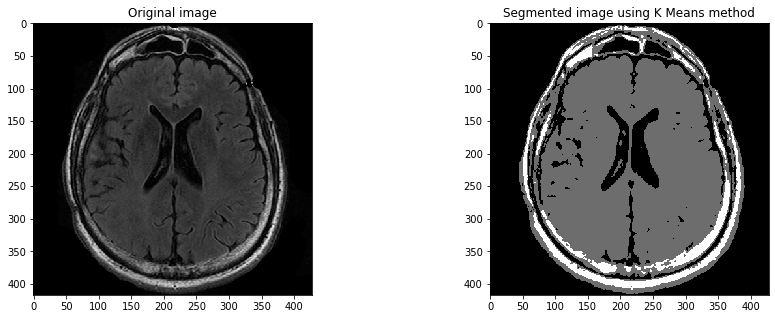

In [34]:
# we assign each sample to the new cluster set whose center is closest
segmented = np.zeros(shape=image.shape, dtype=np.uint8)
for i in range(K):
    segmented[np.where(clusters == i)] = np.round(centers_new[i]).astype(np.uint8)


fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(image, interpolation='none',  cmap='gray') 
ax1.set_title('Original image') 

ax2 = fig.add_subplot(122)
ax2.imshow(segmented, interpolation='none',  cmap='gray')
ax2.set_title('Segmented image using K Means method')

plt.show()

In [35]:
# TODO: Now, you can try with different values of K

Finding the suitable number of clusters is a major point here. Using prior knowledge about the number of tissues in the medical image could be helpful.

## Part 7: Basic Segmentation (Superpixel)



The simple linear iterative clustering (SLIC) is an algorithm for generating superpixels. We can use the skimage.segmentation to find superpixels based on SLIC metohd. For this, take a look at https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic

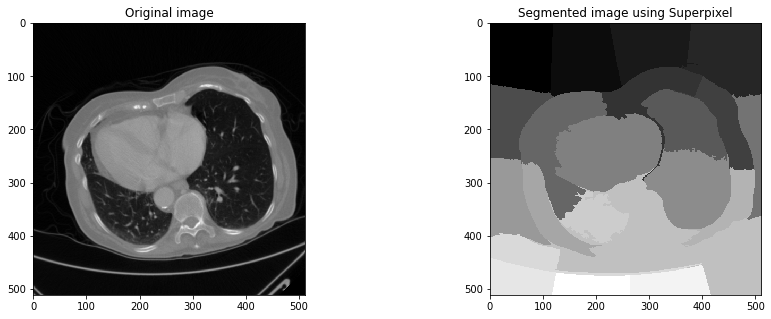

In [36]:
# import the skimage.segmentation package
from skimage.segmentation import slic

image = cv2.imread('img/CT001_146.png') # Load a gray image

# Apply SLIC method (It takes image, and the number of labels in the segmented output image)
segmented_SLIC = slic(image, n_segments = 25)


fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax1.imshow(image, interpolation='none',  cmap='gray') 
ax1.set_title('Original image') 

ax2 = fig.add_subplot(122)
ax2.imshow(segmented_SLIC, interpolation='none',  cmap='gray')
ax2.set_title('Segmented image using Superpixel')

plt.show()


In [37]:
# TODO: Now, you can try with different the number of labels by changing n_segments parameter


#### If you have any question about this tutorial, feel free to find me in this mail 'adele.bitarafan@gmail.com'